In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving imputed features_final.csv to imputed features_final.csv
Saving Optimal_target_with_92_Q3_2점.csv to Optimal_target_with_92_Q3_2점.csv


In [15]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['imputed features_final.csv'])) 
optimal_target = pd.read_csv(io.BytesIO(uploaded['Optimal_target_with_92_Q3_2점.csv'])) 

In [16]:
optimal_target = optimal_target.drop(columns = 'Unnamed: 0')
feature = feature.drop(columns = 'Unnamed: 0')

In [18]:
feature.describe()

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
count,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000
mean,502951.987652,55.442748,0.625056,-278.442748,-609.874944,0.199077,331.432196,-0.095553,80.145256,28.758350,3.098164,3.370428,3.416574,2.901893,2.574622,2.411366,2.960302,2.618122,1.856466,3.550132,6.515164,15.322883,-0.027981,-0.002049,-0.001586,-0.001909,-0.002833,-0.003747,-0.004004,0.012036,-0.002505,-0.004210,-0.001919,-0.003955,-0.020522
std,293006.073632,11.686189,0.484163,305.401815,391.917931,0.399466,251.209878,0.345993,21.012072,5.627361,0.993363,0.842266,0.752965,0.995237,1.126275,0.982517,0.914581,0.891939,1.282044,0.596866,1.644885,4.916685,0.069504,0.016784,0.017352,0.014878,0.016931,0.017627,0.016430,0.027147,0.013098,0.021998,0.018432,0.020840,0.053341
min,329.000000,18.000000,0.000000,-7372.000000,-8741.000000,-0.311379,-274.000000,-3.400000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.125000,-0.125000,-0.250506,-0.333333,-0.250000,-0.285714,-0.200000,-0.166667,-0.125000,-0.333333,-0.251044,-0.250000,-0.875000
25%,252186.250000,47.000000,0.000000,-367.000000,-755.000000,0.000000,167.000000,-0.234297,67.750000,25.666667,2.750000,3.000000,3.000000,2.700000,2.000000,2.000000,2.500000,2.000000,1.000000,3.200000,6.000000,12.500000,-0.048387,-0.000500,0.000000,0.000000,-0.001560,-0.011236,-0.011765,0.000000,0.000000,-0.011765,0.000000,-0.006193,-0.036551
50%,509788.500000,56.000000,1.000000,-191.000000,-529.000000,0.000000,273.000000,-0.076210,80.577463,29.000000,3.091153,3.666667,3.666667,3.000000,2.750000,2.426634,3.000000,2.609484,1.818979,3.800000,7.000000,15.419286,-0.024096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,-0.016411
75%,760948.750000,64.000000,1.000000,-89.000000,-355.000000,0.000000,421.000000,0.036917,94.000000,33.000000,4.000000,4.000000,4.000000,3.691667,3.500000,3.000000,4.000000,3.000000,3.000000,4.000000,8.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000
max,999990.000000,84.000000,1.000000,0.000000,-24.000000,1.000000,2708.000000,8.333333,154.000000,40.000000,4.000000,4.061079,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,8.000000,24.000000,1.666667,0.666667,0.230769,0.153846,0.333333,0.153846,0.285714,0.500000,0.333333,0.500000,0.333333,0.333333,1.000000


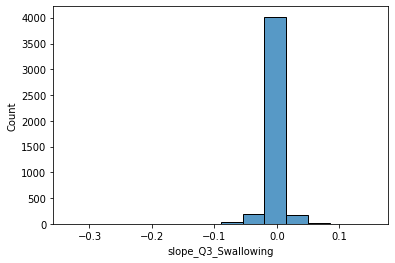

In [20]:
sns.histplot(x = feature['slope_Q3_Swallowing'])

In [25]:
feature = feature[['SubjectID','Age', 'Gender', 'onset_site', 'onset_delta',
       'diag_minus_onset', 'slope_alsfrs_tot',
       'fvc_slope', 'fvc_mean',  'mean_Q10_Respiratory',
       'mean_Bulbar', 'mean_motor', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory']]

##Classification with slope_Q3

In [26]:
feature_slow = feature[feature['slope_Q3_Swallowing']> 0]
feature_medium = feature[feature['slope_Q3_Swallowing']== 0]
feature_fast = feature[feature['slope_Q3_Swallowing']< 0]
slow_list = list(feature_slow['SubjectID'])
medium_list = list(feature_medium['SubjectID'])
fast_list = list(feature_fast['SubjectID'])
print(len(slow_list))
print(len(medium_list))
print(len(fast_list))

441
3029
984


In [30]:
X_full = pd.merge(feature, optimal_target, on = 'SubjectID')
X_slow = pd.merge(feature_slow, optimal_target, on = 'SubjectID')
X_medium = pd.merge(feature_medium, optimal_target, on = 'SubjectID')
X_fast = pd.merge(feature_fast, optimal_target, on = 'SubjectID')

,SubjectID,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,time_opt,status_opt
0,708.0,46.0,1.0,1.0,-1070.0,84.0,-0.021978,-0.061928,51.000000,2.833333,5.666667,20.916667,0.000000,-0.010989,-0.010989,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,-0.010989,35,1
1,3981.0,62.0,1.0,0.0,-210.0,120.0,-0.142857,-0.535109,99.500000,4.000000,7.200000,9.700000,-0.014286,0.014286,-0.014286,-0.014286,-0.028571,-0.028571,0.014286,-0.028571,0.000000,0.000000,70,0
2,5067.0,63.0,0.0,1.0,-449.0,365.0,0.285714,0.142857,62.000000,3.000000,5.500000,18.000000,0.000000,0.071429,-0.071429,0.071429,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,105,0
3,8586.0,40.0,1.0,0.0,-817.0,704.0,-0.070175,-0.151407,77.750000,3.333333,7.000000,16.000000,0.017544,-0.017544,-0.017544,0.000000,-0.017544,0.017544,0.000000,0.000000,-0.035088,-0.017544,219,0
4,11052.0,65.0,1.0,0.0,-310.0,221.0,-0.026772,-0.357143,107.500000,4.000000,7.000000,14.000000,-0.002287,0.001341,-0.000484,-0.010132,0.011024,0.007641,-0.014776,0.014726,-0.032831,-0.002837,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,994895.0,70.0,1.0,1.0,-332.0,151.0,-0.084507,-0.154866,51.893808,3.250000,3.750000,21.000000,-0.014085,-0.028169,-0.014085,0.000000,-0.014085,-0.014085,0.014085,-0.014085,0.000000,0.014085,45,1
510,995893.0,46.0,0.0,1.0,-274.0,62.0,-0.058824,-0.057877,94.283933,4.000000,4.500000,8.750000,0.000000,0.011765,-0.011765,-0.035294,0.000000,0.000000,0.011765,0.000000,-0.011765,0.000000,85,1
511,997336.0,43.0,0.0,0.0,-390.0,349.0,-0.071429,-0.110052,105.800000,4.000000,6.000000,11.500000,-0.011905,0.000000,-0.011905,0.000000,-0.011905,-0.023810,0.000000,0.000000,0.000000,0.000000,91,0
512,999166.0,60.0,1.0,1.0,-999.0,950.0,-0.027239,-0.333333,75.000000,4.000000,7.000000,21.000000,-0.000952,-0.002490,-0.003335,0.009007,-0.000594,-0.012669,-0.008895,-0.025678,-0.036810,-0.002018,390,0


##Create virtual patient for each class

In [32]:
VIRT_slow = pd.DataFrame(X_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_medium = pd.DataFrame(X_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_fast = pd.DataFrame(X_fast.mean()).transpose().iloc[:, 1:-2]

##Fitting model

In [33]:
df_train = X_full.drop(columns='SubjectID')

In [34]:
!pip install lifelines

     |████████████████████████████████| 348kB 2.9MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4035 sha256=974abed4c8bf4d298bf9468009759eb7b3454aebcce31ee522b7af3bcc0e5040
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


### Cox Proprotion Hazard model

In [35]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 3399 total observations, 2234 right-censored observations>

In [37]:
result_cph_slow = cph.predict_survival_function(VIRT_slow)
result_cph_medium = cph.predict_survival_function(VIRT_medium)
result_cph_fast = cph.predict_survival_function(VIRT_fast)

In [38]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 2.4 MB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 23.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 39.3 MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061838 sha256=322146bdbd131ede1df12483fc7877d67ee76fe98859998b08b325fd8bbbb16a
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


### Random Survival Forest

In [39]:
from sksurv.ensemble import RandomSurvivalForest

In [40]:
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [41]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']

In [42]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [44]:
result_rsf_slow = rsf.predict_survival_function(VIRT_slow, return_array=True)
result_rsf_medium = rsf.predict_survival_function(VIRT_medium, return_array=True)
result_rsf_fast = rsf.predict_survival_function(VIRT_fast, return_array=True)

### Accelerated Failure Time model

In [78]:
from lifelines import WeibullAFTFitter

In [79]:
aft = WeibullAFTFitter()
aft.fit(df_train, 'time_opt', 'status_opt', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 3399 total observations, 2234 right-censored observations>

In [81]:
result_wft_slow = aft.predict_survival_function(VIRT_slow)
result_wft_medium = aft.predict_survival_function(VIRT_medium)
result_wft_fast = aft.predict_survival_function(VIRT_fast)

In [43]:
result_cph_slow[result_cph_slow[0]<=0.51].head()

,0
507.0,0.509752
508.0,0.506279
509.0,0.506279
510.0,0.502682
511.0,0.499086


In [51]:
result_cph_medium[result_cph_medium[0]<=0.51].iloc[:10]


,0
576.0,0.509813
577.0,0.509813
578.0,0.509813
579.0,0.509813
580.0,0.509813
582.0,0.509813
588.0,0.504745
589.0,0.499587
592.0,0.499587
594.0,0.499587


In [53]:
result_cph_fast[result_cph_fast[0]<=0.51].iloc[:10]

,0
249.0,0.509596
250.0,0.507149
251.0,0.505519
252.0,0.501454
253.0,0.500638
255.0,0.500638
256.0,0.499820
257.0,0.499002
258.0,0.498185
259.0,0.490871


In [68]:
rsf.event_times_

array([   4.,    7.,    8.,   11.,   12.,   13.,   14.,   15.,   17.,
         21.,   22.,   27.,   28.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   55.,
         56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,   64.,
         65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,   73.,
         74.,   75.,   76.,   77.,   78.,   80.,   81.,   82.,   83.,
         84.,   85.,   86.,   89.,   91.,   92.,   93.,   94.,   95.,
         96.,   97.,   98.,   99.,  100.,  101.,  102.,  103.,  104.,
        105.,  106.,  107.,  108.,  109.,  110.,  111.,  112.,  113.,
        115.,  116.,  117.,  119.,  120.,  121.,  122.,  123.,  124.,
        125.,  126.,  127.,  128.,  129.,  130.,  131.,  132.,  133.,
        134.,  135.,  136.,  137.,  138.,  139.,  140.,  141.,  142.,
        143.,  144.,  145.,  147.,  148.,  149.,  150.,  151.,  152.,
        153.,  154.,

In [67]:
result_rsf_slow

array([[1.        , 0.99958198, 0.99950757, 0.99950757, 0.99950757,
        0.99929939, 0.99916425, 0.99916425, 0.99916425, 0.99909282,
        0.99816856, 0.99816856, 0.99801534, 0.99801534, 0.99801534,
        0.99801534, 0.99757167, 0.9975282 , 0.99716777, 0.99706874,
        0.99681498, 0.99642065, 0.99638362, 0.9961303 , 0.99608864,
        0.99599493, 0.99594493, 0.99594493, 0.99594493, 0.99317521,
        0.99317521, 0.99317521, 0.99317521, 0.99317521, 0.9931315 ,
        0.99301137, 0.99301137, 0.99222983, 0.99222983, 0.99218816,
        0.99218816, 0.99176   , 0.99158296, 0.98926796, 0.98926796,
        0.98926796, 0.98926796, 0.98926796, 0.98926796, 0.98926796,
        0.98879195, 0.98874195, 0.98874195, 0.98874195, 0.98874195,
        0.98874195, 0.98864825, 0.98864825, 0.98847132, 0.98847132,
        0.98847132, 0.98847132, 0.9882706 , 0.9882706 , 0.9882706 ,
        0.9882706 , 0.98800859, 0.98656253, 0.9862861 , 0.98502018,
        0.98413834, 0.98385638, 0.98372975, 0.98

In [69]:
result_rsf_medium

array([[1.        , 0.99983152, 0.99983152, 0.99978607, 0.99978607,
        0.99972357, 0.99972357, 0.99972357, 0.99972357, 0.99972357,
        0.99972357, 0.99972357, 0.99972357, 0.99972357, 0.99972357,
        0.99972357, 0.99931267, 0.99931267, 0.99931267, 0.99925711,
        0.99921865, 0.99915198, 0.99915198, 0.99907923, 0.9989709 ,
        0.99891534, 0.99891534, 0.99891534, 0.99891534, 0.99733978,
        0.99733978, 0.99733978, 0.99733978, 0.99733978, 0.99733978,
        0.99733978, 0.9971569 , 0.99708993, 0.9970373 , 0.9970373 ,
        0.9970373 , 0.99666459, 0.99666459, 0.99573558, 0.99566862,
        0.99566862, 0.99566862, 0.99556349, 0.99556349, 0.99556349,
        0.99475837, 0.99471991, 0.99471991, 0.99468145, 0.99468145,
        0.99461002, 0.99461002, 0.99461002, 0.99461002, 0.99461002,
        0.99461002, 0.99461002, 0.99439585, 0.99439585, 0.99433311,
        0.99433311, 0.99423407, 0.9936696 , 0.99353071, 0.99320716,
        0.99299079, 0.99292829, 0.99289258, 0.99

In [70]:
result_rsf_fast

array([[0.99909454, 0.9987177 , 0.9986552 , 0.99849853, 0.99786925,
        0.99748769, 0.99535333, 0.99520312, 0.99428983, 0.99179921,
        0.98754669, 0.98627789, 0.98435169, 0.98297615, 0.98245079,
        0.98229409, 0.97777166, 0.97497058, 0.97352516, 0.9706855 ,
        0.9692353 , 0.96415627, 0.95121186, 0.94133187, 0.93661072,
        0.93015413, 0.92158475, 0.92012991, 0.91957199, 0.91552353,
        0.91100268, 0.90573879, 0.90391105, 0.90252165, 0.89837617,
        0.89730891, 0.89181453, 0.88532806, 0.88432059, 0.88338096,
        0.8800703 , 0.87271494, 0.86615417, 0.8581069 , 0.85492511,
        0.85270505, 0.85127291, 0.84802716, 0.84447511, 0.84170676,
        0.8276562 , 0.8255058 , 0.82343605, 0.8171464 , 0.81286889,
        0.81197749, 0.80845774, 0.80385192, 0.79865708, 0.79825308,
        0.79792889, 0.79787626, 0.79351423, 0.79132251, 0.78913282,
        0.78899438, 0.78367201, 0.75674198, 0.75191892, 0.75082552,
        0.74803342, 0.74766891, 0.74651263, 0.74

In [83]:
result_wft_slow[result_wft_slow[0]<=0.51].head()

,0
537.0,0.507162
539.0,0.505063
542.0,0.501921
543.0,0.500875
544.0,0.499831


In [84]:
result_wft_medium[result_wft_medium[0]<=0.51].head()

,0
611.0,0.508941
613.0,0.507099
614.0,0.506179
629.0,0.492466
631.0,0.490650


In [86]:
result_wft_fast[result_wft_fast[0]<=0.51].head()

,0
248.0,0.509018
249.0,0.506750
250.0,0.504485
251.0,0.502225
252.0,0.499970


In [64]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [66]:
from lifelines.utils import median_survival_times

## Comparing Mean Survival function

### Slow progresser

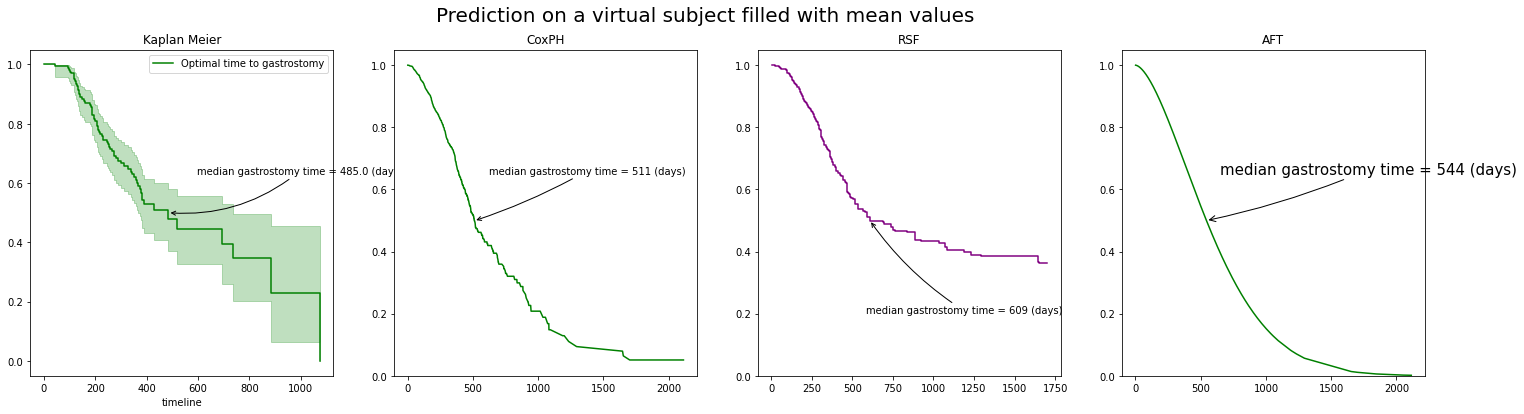

In [87]:
plt.figure(figsize=(25, 6))

plt.subplot(141)
OPT = kmf.fit(X_slow["time_opt"], X_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(142)
plt.plot(result_cph_slow.index, result_cph_slow, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 511 (days)", xy=(511, 0.499086)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(143)
for i, s in enumerate(result_rsf_slow):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 609 (days)", xy=(609, 0.49955696)
                , xytext=(694-110, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1"))
plt.title('RSF')

plt.subplot(144)
plt.plot(result_wft_slow.index, result_wft_slow[0], marker='None', color='green')
plt.title("Weibull AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 544 (days)", xy=(544, 0.499831)
                , xytext=(539+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"), fontsize=15)
plt.title('AFT')

plt.suptitle('Prediction on a virtual subject filled with mean values', fontsize=20)
plt.show()

### Medium progressor

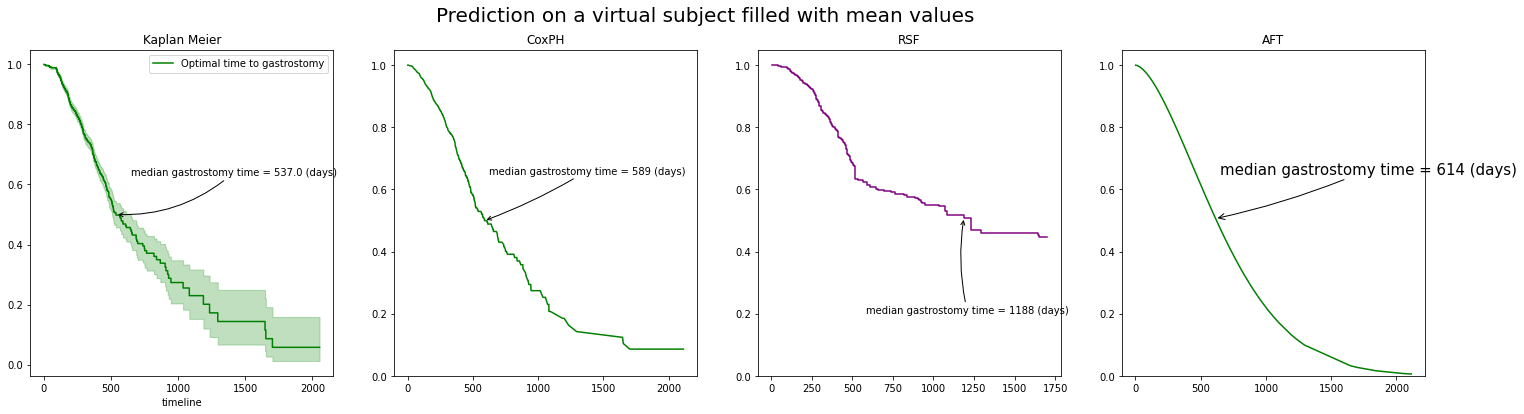

In [88]:
plt.figure(figsize=(25, 6))

plt.subplot(141)
OPT = kmf.fit(X_medium["time_opt"], X_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(142)
plt.plot(result_cph_medium.index, result_cph_medium, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 589 (days)", xy=(589, 0.499587)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(143)
for i, s in enumerate(result_rsf_medium):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 1188 (days)", xy=(1188, 0.50842286)
                , xytext=(694-110, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1"))
plt.title('RSF') 

plt.subplot(144)
plt.plot(result_wft_medium.index, result_wft_medium[0], marker='None', color='green')
plt.title("Weibull AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 614 (days)", xy=(614, 0.506179)
                , xytext=(539+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"), fontsize=15)
plt.title('AFT')

plt.suptitle('Prediction on a virtual subject filled with mean values', fontsize=20)
plt.show()

### Fast progressor

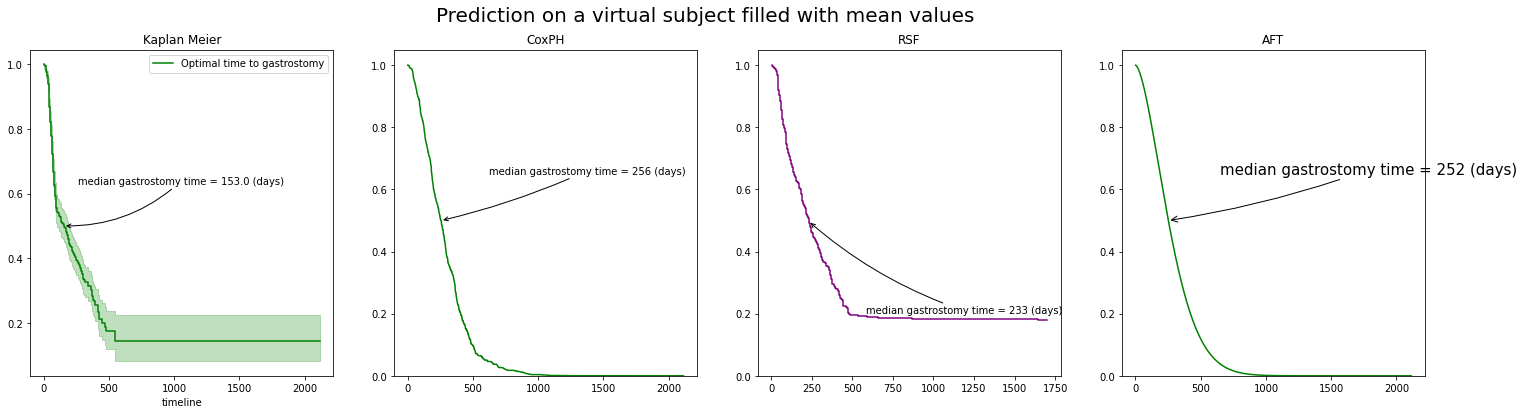

In [91]:
plt.figure(figsize=(25, 6))

plt.subplot(141)
OPT = kmf.fit(X_fast["time_opt"], X_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(142)
plt.plot(result_cph_fast.index, result_cph_fast, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 256 (days)", xy=(256, 0.499820)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(143)
for i, s in enumerate(result_rsf_fast):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 233 (days)", xy=(233, 0.49675274)
                , xytext=(694-110, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1"))
plt.title('RSF')

plt.subplot(144)
plt.plot(result_wft_fast.index, result_wft_fast[0], marker='None', color='green')
plt.title("Weibull AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 252 (days)", xy=(252, 0.499970)
                , xytext=(539+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"), fontsize=15)
plt.title('AFT')

plt.suptitle('Prediction on a virtual subject filled with mean values', fontsize=20)
plt.show()